In [1]:
import pyodbc
from azure.identity import ManagedIdentityCredential
from azure.keyvault.secrets import SecretClient
import pandas as pd
 
# get credentials from the Azure ML workspace service principal
credential = ManagedIdentityCredential()
# access the KeyVault in another resource group
KVUri = "https://bdf-dataeng-kv.vault.azure.net"
kVClient = SecretClient(vault_url=KVUri, credential=credential)
 
# create datalake connection
def get_dl_conn():
    con = pyodbc.connect(
        driver="{ODBC Driver 17 for SQL Server}",
        server=kVClient.get_secret("datalake-sqlpool-server-prd").value,
        port=1433,
        database=kVClient.get_secret("datalake-sqlpool-dbname-prd").value,
        uid=kVClient.get_secret("datalake-sqlpool-user-prd").value,
        pwd=kVClient.get_secret("datalake-sqlpool-psw-prd").value,
    )
    print("Connect to Database \U00002705")
    return con



 
class DLorm:
    def __init__(self, connector) -> None:
        self.connector = connector
 
    def get_query(self, query: str, **kwargs) -> pd.DataFrame:
        return pd.read_sql(query, con=self.connector, **kwargs)


In [2]:
con = get_dl_conn()
datalake = DLorm(con)

Connect to Database ✅


In [3]:
query_updated="SELECT  DISTINCT user_id, procedure_date FROM ds.measures_filtered WHERE is_morning = 1 AND is_first = 1 AND user_id in( SELECT user_id FROM ds.users WHERE country_name = 'Thailand' AND gender_desc = 'female')"

In [4]:
df_query_updated = datalake.get_query(query_updated)

/tmp/ipykernel_8582/2746889058.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, con=self.connector, **kwargs)


In [5]:
df_query_updated

,user_id,procedure_date
0,3913,2020-01-24
1,11378,2020-08-17
2,11981,2022-11-15
3,16108,2022-09-01
4,11466,2022-09-26
...,...,...
764028,9798,2023-06-16
764029,4494,2021-04-28
764030,3915,2020-06-28
764031,3502,2020-07-15


In [6]:
joined=pd.DataFrame(df_query_updated)
joined.head()

,user_id,procedure_date
0,3913,2020-01-24
1,11378,2020-08-17
2,11981,2022-11-15
3,16108,2022-09-01
4,11466,2022-09-26


In [7]:
# Function to find uninterrupted chunks for a given user ID
def find_chunks(user_id, df):
    # Filter DataFrame for the given user ID
    user_data = df[df['user_id'] == user_id]
    # Sort user data by procedure date
    user_data = user_data.sort_values(by='procedure_date')
    # Initialize variables
    current_chunk_start = None
    current_chunk_end = None
    chunk_counter = 1
    chunks = {}
    # Iterate over procedure dates for the user
    for date in user_data['procedure_date']:
        if current_chunk_start is None:
            current_chunk_start = date
            current_chunk_end = date
        elif date == current_chunk_end + pd.Timedelta(days=1):
            current_chunk_end = date
        else:
            # Add current chunk to dictionary
            chunk_name = f"chunk{chunk_counter}"
            chunk_length = (current_chunk_end - current_chunk_start).days + 1
            chunks[chunk_name] = {'start_date': current_chunk_start, 'end_date': current_chunk_end, 'length': chunk_length}
            # Start a new chunk
            chunk_counter += 1
            current_chunk_start = date
            current_chunk_end = date
    # Add the last chunk to dictionary
    if current_chunk_start is not None:
        chunk_name = f"chunk{chunk_counter}"
        chunk_length = (current_chunk_end - current_chunk_start).days + 1
        chunks[chunk_name] = {'start_date': current_chunk_start, 'end_date': current_chunk_end, 'length': chunk_length}
    return chunks


In [8]:

user_id = 15775  
chunks_dict = find_chunks(user_id, joined)
print(chunks_dict)

{'chunk1': {'start_date': datetime.date(2021, 2, 14), 'end_date': datetime.date(2021, 2, 14), 'length': 1}, 'chunk2': {'start_date': datetime.date(2021, 2, 17), 'end_date': datetime.date(2021, 3, 16), 'length': 28}, 'chunk3': {'start_date': datetime.date(2021, 3, 18), 'end_date': datetime.date(2021, 4, 6), 'length': 20}, 'chunk4': {'start_date': datetime.date(2021, 4, 8), 'end_date': datetime.date(2021, 4, 9), 'length': 2}, 'chunk5': {'start_date': datetime.date(2021, 4, 11), 'end_date': datetime.date(2021, 4, 19), 'length': 9}, 'chunk6': {'start_date': datetime.date(2021, 4, 21), 'end_date': datetime.date(2021, 5, 5), 'length': 15}, 'chunk7': {'start_date': datetime.date(2021, 5, 16), 'end_date': datetime.date(2021, 5, 17), 'length': 2}, 'chunk8': {'start_date': datetime.date(2021, 5, 19), 'end_date': datetime.date(2021, 6, 4), 'length': 17}, 'chunk9': {'start_date': datetime.date(2021, 6, 8), 'end_date': datetime.date(2021, 6, 8), 'length': 1}, 'chunk10': {'start_date': datetime.date

In [9]:

user_id = 15775

# Get chunks dictionary for user ID
chunks_dict = find_chunks(user_id, joined)

# Print start date, end date, and length of each chunk
for chunk_num, chunk_info in chunks_dict.items():
    print(f'Chunk {chunk_num}:')
    print(f'Start date: {chunk_info["start_date"]}')
    print(f'End date: {chunk_info["end_date"]}')
    print(f'Length: {chunk_info["length"]}\n')

Chunk chunk1:
Start date: 2021-02-14
End date: 2021-02-14
Length: 1

Chunk chunk2:
Start date: 2021-02-17
End date: 2021-03-16
Length: 28

Chunk chunk3:
Start date: 2021-03-18
End date: 2021-04-06
Length: 20

Chunk chunk4:
Start date: 2021-04-08
End date: 2021-04-09
Length: 2

Chunk chunk5:
Start date: 2021-04-11
End date: 2021-04-19
Length: 9

Chunk chunk6:
Start date: 2021-04-21
End date: 2021-05-05
Length: 15

Chunk chunk7:
Start date: 2021-05-16
End date: 2021-05-17
Length: 2

Chunk chunk8:
Start date: 2021-05-19
End date: 2021-06-04
Length: 17

Chunk chunk9:
Start date: 2021-06-08
End date: 2021-06-08
Length: 1

Chunk chunk10:
Start date: 2021-06-16
End date: 2021-06-16
Length: 1

Chunk chunk11:
Start date: 2021-06-19
End date: 2021-06-24
Length: 6

Chunk chunk12:
Start date: 2021-06-26
End date: 2021-06-27
Length: 2

Chunk chunk13:
Start date: 2021-07-01
End date: 2021-07-02
Length: 2

Chunk chunk14:
Start date: 2021-07-07
End date: 2021-07-27
Length: 21

Chunk chunk15:
Start dat

In [13]:
import matplotlib.pyplot as plt

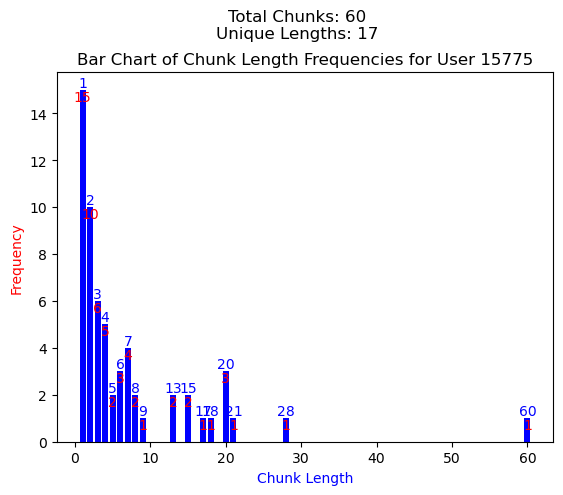

In [23]:

user_id = 15775

chunks_dict = find_chunks(user_id, joined)

chunk_lengths = [chunk['length'] for chunk in chunks_dict.values()]


freq_dict = {}
for length in chunk_lengths:
    if length in freq_dict:
        freq_dict[length] += 1
    else:
        freq_dict[length] = 1


fig, ax = plt.subplots()
ax.bar(freq_dict.keys(), freq_dict.values(), color='blue')
ax.set_xlabel('Chunk Length', color='blue')
ax.set_ylabel('Frequency', color='red')
ax.tick_params(axis='y', labelcolor='black')
ax.set_title(f'Bar Chart of Chunk Length Frequencies for User {user_id}')


for length, freq in freq_dict.items():
    ax.text(length, freq, f'{length}', ha='center', va='bottom', color='blue')
    ax.text(length, freq, f'{freq}', ha='center', va='top', color='red')


desc = f'Total Chunks: {len(chunk_lengths)}\nUnique Lengths: {len(freq_dict)}'
plt.gcf().text(0.5, 0.95, desc, ha='center', fontsize=12)

plt.show()

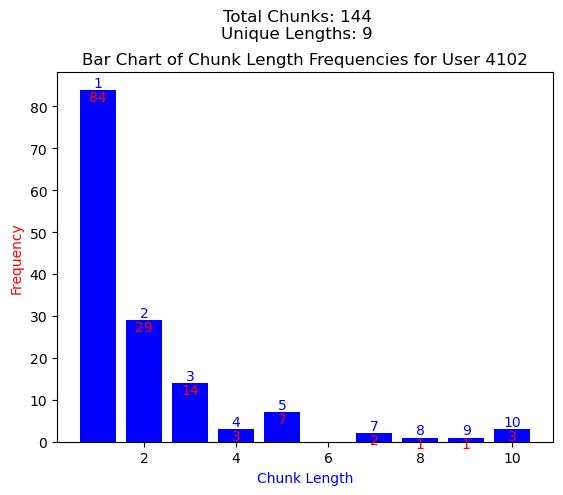

In [22]:

user_id = 4102

chunks_dict = find_chunks(user_id, joined)

chunk_lengths = [chunk['length'] for chunk in chunks_dict.values()]


freq_dict = {}
for length in chunk_lengths:
    if length in freq_dict:
        freq_dict[length] += 1
    else:
        freq_dict[length] = 1


fig, ax = plt.subplots()
ax.bar(freq_dict.keys(), freq_dict.values(), color='blue')
ax.set_xlabel('Chunk Length', color='blue')
ax.set_ylabel('Frequency', color='red')
ax.tick_params(axis='y', labelcolor='black')
ax.set_title(f'Bar Chart of Chunk Length Frequencies for User {user_id}')


for length, freq in freq_dict.items():
    ax.text(length, freq, f'{length}', ha='center', va='bottom', color='blue')
    ax.text(length, freq, f'{freq}', ha='center', va='top', color='red')
    ax.bar(length, freq, color=['blue', 'red'])  


desc = f'Total Chunks: {len(chunk_lengths)}\nUnique Lengths: {len(freq_dict)}'
plt.gcf().text(0.5, 0.95, desc, ha='center', fontsize=12)

plt.show()